<div>
<img align="left" src="data_sig_logo.jpg" width="450"/>
</div>
<br/>

### https://datasig.ac.uk/examples

# Path Signature Methodology for Landmark-based Human Action Recognition

This notebook is based on the paper
> Weixin Yang, Terry Lyons, Hao Ni, Cordelia Schmid, Lianwen Jin, "Developing the Path Signature Methodology and its Application to Landmark-based Human Action Recognition", arXiv preprint arXiv:1707.03993v2, 2019

which is available as an arXiv __[preprint](https://arxiv.org/ftp/arxiv/papers/1707/1707.03993.pdf)__. 

Human action recognition is a challenging task in computer vision with many potential applications, ranging from human-computer interaction and video understanding to video surveillance, behavioural analysis and many more. In this task we are given a short video clip showing one person (or possibly several) performing exactly one action and the task is to output the action that was performed in the video.

In this notebook we give an introduction to the methodology developed in above paper. We begin with explaining the landmark-based approach and why it is a desirable approach. We then show how to generate a feature set based on above paper and train a simple classifier on the __[Joint-annotated Human Motion Data Base (JHMDB)](http://jhmdb.is.tue.mpg.de/)__ dataset.

We begin by setting up the coding environment.

### Import Packages

In [4]:
import os.path
import sys
import zipfile

from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch

from datasetloader import JHMDB
from psfdataset import PSFDataset, transforms

In [5]:
import util

In [6]:
# from moviepy.config import check
# check()

## Download and Load the Dataset

In [7]:
DATASET_PATH = os.path.join("datasets", "jhmdb_dataset")

ZIP_URLS = (
    ("http://files.is.tue.mpg.de/jhmdb/JHMDB_video.zip", "videos"),
    ("http://files.is.tue.mpg.de/jhmdb/splits.zip", "splits"),
    ("http://files.is.tue.mpg.de/jhmdb/sub_splits.zip", "sub_splits"),
    ("http://files.is.tue.mpg.de/jhmdb/joint_positions.zip", "joint_positions"),
)

for zip_url, target_dir in ZIP_URLS:
    zip_path = os.path.join(DATASET_PATH, zip_url.split("/")[-1])
    target_dir = os.path.join(DATASET_PATH, target_dir)

    if not os.path.exists(target_dir) and not os.path.exists(zip_path):
        try:
            os.makedirs(os.path.dirname(zip_path), exist_ok=True)
            util.download(zip_url, zip_path)

            if target_dir.split("/")[-1] != "sub_splits":
                with zipfile.ZipFile(zip_path, "r") as zip_ref:
                    zip_ref.extractall(DATASET_PATH)
            else:
                with zipfile.ZipFile(zip_path, "r") as zip_ref:
                    zip_ref.extractall(target_dir)

            if target_dir.split("/")[-1] == "videos":
                os.rename(
                    os.path.join(DATASET_PATH, "ReCompress_Videos"),
                    os.path.join(DATASET_PATH, "videos"),
                )

        finally:
            if os.path.exists(zip_path):
                os.remove(zip_path)

In [8]:
# load the raw data
dataset = JHMDB(DATASET_PATH)
dataset.set_cols("video-filename", "keypoints2D")

21it [00:00, 126.60it/s]


## Landmark-based Human Action Recognition

In landmark-based human action recognition, rather than use RGB video data directly, we use a set of points, the landmarks, which describe the positions of some of the major joints or parts of the human body such as shoulders, hips, knees etc. One can connect these landmarks to form a skeleton figure as shown in the following animation:

In [9]:
sample = dataset[200]
util.display_animation(
    sample["video-filename"], sample["keypoints2D"], include_source_video=False
)

Note that the connections between landmarks are only for visualisation and we do not make use of them in our action recognition approach. Approaches which do make use of these connections are generally referred to as skeleton-based human action recognition. We choose a landmark-based approach as it ensures that the method is applicable to other landmark data where we may not understand the interactions between different landmarks as well as we do for the human body.

The landmark-based approach has multiple technical advantages:

 - **Dimensionality reduction:** We commonly use between 15 and 25 landmarks in 2 or 3 dimensions. This means a person in a single frame is described by a 30-75 dimensional vector. This is a much smaller input vector for our model compared to an RGB image.

 - **Extract and separate human movement from other information:** Notice how in above animation you can easily tell what the person is doing. This shows that the landmark data contains all necessary information about human movement for our task of action recognition, while discarding other information contained in the visual scene.

Moreover, using landmarks rather than RGB data has a practical advantage which is crucial for many real-world applications:

 - **De-identification:** Using landmarks avoids retaining personally identifiable information contained in the source video. In many applications, protecting people's identities is either a regulatory requirement, or crucial for ethical use of the technology.
   
Landmark data has increasingly become available using commercial depth camera systems such as the Microsoft Kinect, as well as advances in human pose estimation research. This has led to the availability of free pose estimation tools such as __[OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose)__ and __[AlphaPose](https://github.com/MVIG-SJTU/AlphaPose)__. While these pose estimation tools have increased the availability of pose data and made applications outside a lab environment possible, it is important to note that these systems do often still suffer from noise, making the action recognition task harder. Most pose estimation software will output a confidence score for its prediction of each of the landmark coordinates. The methodology we are presenting in this notebook is general enough to include these confidence scores as extra dimensions of the data. Using the confidence scores one can increase the performance of the model using landmarks obtained by pose estimation to almost the same accuracy as achieved using noise-free groundtruth landmarks. The experimental results for this can be found in the above paper.

---

The dataset used in this notebook, __[Joint-annotated Human Motion Data Base (JHMDB)](http://jhmdb.is.tue.mpg.de/)__ provides a collection of short video clips extracted from YouTube. Each clip represents a single human action and is labelled accordingly. Moreover, each clip in the dataset includes human-sourced 'ground truth' landmarks representing joint locations. Note that in the aforementioned paper by Yang et al., input features are alternatively constructed from estimated poses and ground truth landmark data. The authors observe that providing that confidence scores are used, pose estimation techniques yield competitive performance, compared to using ground truth landmark data. For the purpose of simplicity, we use ground truth landmark data as input features in this notebook.

Here are a few more examples with a side-by-side view of the original RGB video we see and the landmark representation the classifier sees:

In [10]:
sample = dataset[50]
util.display_animation(sample["video-filename"], sample["keypoints2D"])

In [11]:
sample = dataset[100]
util.display_animation(sample["video-filename"], sample["keypoints2D"])

In [12]:
sample = dataset[200]
util.display_animation(sample["video-filename"], sample["keypoints2D"])

## Path Signature Methodology
You can see that in this dataset each person is represented by 15 landmarks in 2D. Thus the skeleton in an individual frame can be considered a point in $\mathbb{R}^{15}\times\mathbb{R}^2\simeq\mathbb{R}^{30}$. We can then view a sequence of skeletons $x=(x_0,...,x_N)\subset\mathbb{R}^{30}$ from a video clip with $N+1$ frames as a discretisation of an underlying continuous path $P:[0,1]\rightarrow\mathbb{R}^{30}$, where each frames skeleton $x_i$ is a sample of the human motion at a time $t=\frac{i}{N}\in[0,1]$. Classifying the action now means making sense of this path.

### The Path Signature
The path signature is one of the central objects of the mathematical field of rough path theory. It is a powerful tool to efficiently and concisely describe a path like the continuous path $P:[0,1]\rightarrow\mathbb{R}^{30}$ above. The path signature describes the path independently of its time parametrisation but preserves the order in which things happen. Thus it is invariant to e.g. the sampling rate, a desirable property since a human action itself is invariant to the frame rate of the video recording or the speed at which the action was performed. Moreover, the signature is robust with respect to missing frames.

The signature is defined as repeated integrals of the path $P$. If we denote the $d$ components of the path $P$ at time $t$ by $(X^1_t,\ldots,X^d_t)$ (in our case $d=30$) then the first order integrals of the path $P$ are given by 
$${S(P)}^{i}=\int\limits_{0<s<1} d X_{s}^{i}=X_{1}^{i}-X_{0}^{i}$$
for every $i\in\{1,\ldots,d\}$. Similarly the second order integrals are given by 
$${S(P)}^{i, j}=\iint\limits_{0<t_1<t_2<1} d X_{t_1}^{i} d X_{t_2}^{j}$$
for every $i,j\in\{1,\ldots,d\}$. Repeating this process, for any integer $k\geq1$ the repeated integral of order $k$ is given by
$${S(P)}^{i_{1}, \ldots, i_{k}}=\idotsint\limits_{0<t_{1}<\cdots<t_{k}<1} d X_{t_{1}}^{i_{1}} \ldots d X_{t_{k}}^{i_{k}}$$
for every collection of indices $i_1,\ldots,i_k\in\{1,\ldots,d\}$. The signature of the path $P$ is now given by the infinite sequence of all such repeated integrals
$${S(P)}=\left(1, {S(P)}^{1}, \ldots, {S(P)}^{d}, {S(P)}^{1,1}, {S(P)}^{1,2}, \ldots\right)$$
The number of integrations $k\in\mathbb{N}$ over the path $P$ is commonly referred to as the level of the signature. Each of the $k$ integrations is along one coordinate axis. The index set $i_1,\ldots,i_k$ describes the set of coordinate axes and the order in which we perform these $k$ integrations. For a path in $d$ dimensions we have $d^k$ possible choices for this index set $i_1,\ldots,i_k$ of integrations. This means the number of terms in the sequence $Sig(x)$ grows exponentially with the level $k$.

Since the full signature is an infinite sequence of repeated integrals in practice we have to choose a finite truncation by computing the integrals only up to a finite level $N$, i.e. $0\leq k\leq N$ in above equation. This is referred to as the Signature of level $N$, denoted by $Sig^N(x)$. Since the number of integrals grows exponentially with each extra level commonly only few (less than 10) levels of the signature are computed.

In practice, to compute the signature from a skeleton sequence $x=(x_0,...,x_N)\subset\mathbb{R}^{30}$ we assume the path $P$ to be the piecewise linear interpolation of the skeleton sequence, i.e. $P(\frac{i}{N})=x_i$ for each $i\in\{0,\ldots,N\}$, and linear in between the sample points.

Some more detail on the path signature can be found in our main reference, the paper by Yang et al., or in one of the following references:

* I. Chevyrev and A. Kormilitzin, "A Primer on the Signature Method in Machine Learning", arXiv preprint arXiv:1603.03788, 2016, https://arxiv.org/pdf/1603.03788.pdf

* T. Lyons, "Rough paths, Signatures and the modelling of functions on streams", In <i>Proceedings of the International Congress of Mathematicians: Seoul</i>, pp. 163‐184, 2014, (available on arXiv: https://arxiv.org/pdf/1405.4537.pdf)

* T. Lyons, M. J. Caruana and T. Lévy, "Differential Equations Driven by Rough Paths: Ecole d’Eté de Probabilités de Saint-Flour XXXIV-2004", <i>Lecture Notes in Mathematics École d'Été de Probabilités de Saint-Flour</i>, Springer 2007, DOI https://doi.org/10.1007/978-3-540-71285-5

### Path Transformations
The full signature $Sig(x)$ determines the path essentially uniquely, but we only consider a finite truncation $Sig^N(x)$. The k-th term of the signature is of size $\mathcal{O}(\frac{1}{k!})$ so often this may not be an issue as the first $N$ levels of the signature contain the largest terms. But if the function we try to learn strongly depends on higher order terms of the signature then important information has been lost.
In order tackle this problem a number of path transformations have been introduced which help to capture various important properties of a path in lower order terms of the signature. A description of the variety of the path transformations and their effects can be found in the above mentioned paper. We are going to describe the selection of path transformations we are using in this notebook and illustrate them with easy examples.

0. **Crop & Normalize**

    These are not path signature specific path transformations. As it is common in machine learning we crop and normalize the landmark coordinates to be within the interval $[-1,1]$ by cropping to the landmark bounding box, extending the shorter side symmetrically to a square box and then scaling the box down to the target interval.


1. **Spatio-Temporal Path**

    There are two kinds of path transformations, spatial and temporal transformations, which assume a different structure of the path.
    
    Transformations such as the crop and normalise above are spatial transformations, operating on the spatial coordinates at each individual time step not on a time series. Similarly it is possible to view a set of $n$ landmarks as $n$ samples of a path in $\mathbb{R}^2$ and then take the signature of each of those spatial paths of length $n$. As an example, you could take all possible pairs of landmarks within one frames and consider each pair a path with 2 sample points. Thus spatial transformations expect a sequence of the form `[frame][landmark][coordinates]` to loop over the frames and process the spatial coordinates.
    
    Temporal transformations on the other hand operate on all or a subset of the spatial coordinates across time, some examples are presented below. For this reason they expect a sequence of the form `[element][frame][coordinates]` which is referred to as a spatio-temporal path. Thus after applying all spatial transformations we want to use we need to transform from a spatial path into a spatio-temporal path before proceeding with temporal transformations.
    
    
2. **Multi-delayed transformation**

    To better encode temporal dependencies one can use the multi-delayed transformation of the  path. For this the path is augmented with several delayed versions of itself so that at any point of the path the information of several timesteps is available. The individual copies of the path are zero-padded as required.
    
    As an example, the path $[[2,3],[4,6],[8,9]]$ with a delay of 1 turns into $[[[2,3],[0,0]],[[4,6],[2,3]],[[8,9],[4,6]],[[0,0],[8,9]]]$. (Note our implementation adds another dimension and outputs in a path in $\mathbb{R}^{d+1}\times\mathbb{R}^n$ where $d$ is the delay and $n$ is the dimension of the original path.
    
    
3. **Temporal disintegration into dyadic path signatures**

    For long paths it can often be more efficient (comparable performance on a smaller feature set) to consider lower level terms of signatures on intermediate time intervals rather than higher order terms of the signature of the full path. An efficient way of doing this is to take signatures of a dyadic hierarchical structure. At each dyadic level we split the intervals of the previous level in half, i.e. level 0 contains the whole path, level 1 its two halves, level 2 the four quarters etc., as can be seen on the left in the diagram below. To avoid breaking events occurring near the splits into subintervals we can consider overlapping dyadic intervals, i.e. three halfs $[0,T/2]$, $[T/4,3T/4]$ and $[T/2,T]$ on level 1, 7 quarters $[0,T/4],[T/8,3T/8],...,[3T/4,T]$ etc., as can be seen on the right in the diagram below.
    
    ![Visualisation of (overlapping) dyadic intervals](dyadic_intervals.png)
    
    To illustrate this point in our reference paper Yang et al. state that they observed better performance for taking signatures of level 2 over a overlapping dyadic hierarchy up to level 2 (i.e. the whole interval, halves and quarters) than taking signatures of level 5 of the whole time interval. Since the size of the truncated signature grows exponentially with the level, taking signatures of 1 full + 3 half + 7 quarter = 11 pieces of level 2 results in a considerably smaller feature set than a level 5 signature of the whole sequence.

In [13]:
tr = transforms.Compose(
    [
        transforms.spatial.Crop(),
        transforms.spatial.Normalize(),
        transforms.SpatioTemporalPath(),
        transforms.temporal.MultiDelayedTransformation(2),
        transforms.temporal.DyadicPathSignatures(dyadic_levels=1, signature_level=3),
    ]
)

### Generate the Path Signature Feature Set

In [14]:
trainingset = PSFDataset(transform=tr)
testset = PSFDataset(transform=tr)

dataset.set_cols("keypoints2D", "action")
trainingset.fill_from_iterator(dataset.iterate("1", "train", return_tuple=True))
testset.fill_from_iterator(dataset.iterate("1", "test", return_tuple=True))

print("Number of trainingset elements:", len(trainingset))
print("Number of testset elements", len(testset))
print("Dimension of feature vector:", trainingset.get_data_dimension())

660it [00:04, 146.20it/s]
268it [00:01, 149.81it/s]

Number of trainingset elements: 660
Number of testset elements 268
Dimension of feature vector: 3600


#### Optional: Save & Load feature sets
If you want to save your feature set for future use run the following cell:

In [15]:
trainingset.save("jhmdb_train")
testset.save("jhmdb_test")

If you want to load a previously saved feature set run the following cell:

In [16]:
# only run if you want to load the dataset from previous run
# transform=tr is not strictly necessary here, it just means that trainingdataset.get_description() will have info
# about the dataset structure
trainingset = PSFDataset(transform=tr)
trainingset.load("jhmdb_train")
print("Number of trainingset elements:", len(trainingset))
print("Dimension of feature vector:", trainingset.get_data_dimension())
# transform=tr is not strictly necessary here, it just means that testdataset.get_description() will have info
# about the dataset structure
testset = PSFDataset(transform=tr)
testset.load("jhmdb_test")
print("Number of testset elements:", len(testset))

Number of trainingset elements: 660
Dimension of feature vector: 3600
Number of testset elements: 268


## Learn an action classifier

### Setup PyTorch
Set random seed:

In [17]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

Train on GPU if available:

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


### Define the Learning Framework
#### The Signature is a Universal Approximator - Learn a Linear Model
The aim of the path signature methodology is not to replace deep learning or any other machine learning techniques but to complement them. The signature can be thought of as a <b>"universal nonlinearity"</b>, every continuous function of a
path may be approximated arbitrarily well by a linear function of its signature. This is clearly a very desirable property, mathematical details and proofs can be found in the papers referenced in the section introducing the path signature.

The universality of the signature and the various path transformations allow us to learn a simple _linear function_ on top of our path signature feature set to do the classification and achieve strong results. For research exploring using the path signature transform in combination with deep learning consider e.g. the following papers and the references therein:
* P. Kidger, P. Bonnier, I. Perez Arribas, C. Salvi and T. Lyons, "Deep Signature Transforms", In <i>Advances in Neural Information Processing Systems 32</i>, pp. 3105-3115, 2019, http://papers.nips.cc/paper/8574-deep-signature-transforms.pdf
* S. Liao, T. Lyons, W. Yang and H. Ni, "Learning stochastic differential equations using RNN with log signature features",  arXiv preprint arXiv:1908.08286, 2019, https://arxiv.org/abs/1908.08286

In this notebook we are not using any deep learning, but learn a <i>linear classifier</i>. This has the advantages that it is easy to train and leads to an interpretable classifier. To determine which features are most important for the classifiers decision we only need to find the largest activations of the linear map. The paper cited above does this for their final, most complex feature set and identifies which combinations of joints, and which time intervals are most relevant for the classifiers decisions.

In [19]:
class LinearClassifierNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        self.linear1 = torch.nn.Linear(input_dim, 2048)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.output = torch.nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = self.output(x)
        return x


model = LinearClassifierNet(
    input_dim=trainingset.get_data_dimension(), output_dim=len(JHMDB.actions)
)
model.to(device=device, dtype=torch.double)

LinearClassifierNet(
  (linear1): Linear(in_features=3600, out_features=2048, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=2048, out_features=21, bias=True)
)

#### Set the hyperparameters

In [20]:
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 20

#### Create the Loss & Optimizer
We train using the popular ADAM optimizer and the Cross Entropy loss which is standard for multi-class classification tasks.

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#### Create PyTorch DataLoaders

In [22]:
training_loader = torch.utils.data.DataLoader(
    trainingset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=1
)

### Train the Model
Define standard functions to perform one epoch of training on the training data and to test the network on the test data.

In [23]:
def train_network(epoch):
    model.train()
    cumulated_loss = 0.0
    for i, data in tqdm(
        enumerate(training_loader), desc="Epoch " + str(epoch), leave=False
    ):
        inputs, labels = data[0].to(device), data[1].to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        cumulated_loss += loss.item()
    return cumulated_loss / len(training_loader)


def test_network():
    cumulated_outputs = np.array([])
    cumulated_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            cumulated_loss += loss.item()

            outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            cumulated_outputs = np.concatenate(
                (cumulated_outputs, outputs.cpu().numpy()), axis=None
            )
        test_loss = cumulated_loss / len(test_loader)
        return test_loss, cumulated_outputs

Train the model for the number of epochs defined above:

In [24]:
# Print initial accuracy before training
__, outputs = test_network()
acc = accuracy_score(testset.get_labels(), outputs)
print("Initial accuracy:", acc)

for epoch in trange(EPOCHS, desc="Training"):
    train_loss = train_network(epoch)
    test_loss, outputs = test_network()

    acc = accuracy_score(testset.get_labels(), outputs)
    print("train_loss:", train_loss, "\ttest_loss:", test_loss, "\tAccuracy:", acc)

Initial accuracy: 0.07462686567164178


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: 0it [00:00, ?it/s]

train_loss: 2.67984563981049 	test_loss: 2.321146896122222 	Accuracy: 0.40671641791044777


Epoch 1: 0it [00:00, ?it/s]

train_loss: 1.9281333413738602 	test_loss: 1.9524560557589443 	Accuracy: 0.4552238805970149


Epoch 2: 0it [00:00, ?it/s]

train_loss: 1.5590578617233084 	test_loss: 1.771954905842492 	Accuracy: 0.5


Epoch 3: 0it [00:00, ?it/s]

train_loss: 1.3499080530711292 	test_loss: 1.6906147819891952 	Accuracy: 0.5373134328358209


Epoch 4: 0it [00:00, ?it/s]

train_loss: 1.1950351989632129 	test_loss: 1.5559955797438962 	Accuracy: 0.582089552238806


Epoch 5: 0it [00:00, ?it/s]

train_loss: 1.0968627104956181 	test_loss: 1.4931222112489686 	Accuracy: 0.5970149253731343


Epoch 6: 0it [00:00, ?it/s]

train_loss: 0.9999512039303988 	test_loss: 1.4838266136088383 	Accuracy: 0.5597014925373134


Epoch 7: 0it [00:00, ?it/s]

train_loss: 0.9222132221339472 	test_loss: 1.400510055105175 	Accuracy: 0.6305970149253731


Epoch 8: 0it [00:00, ?it/s]

train_loss: 0.8711392020980921 	test_loss: 1.3712672475698198 	Accuracy: 0.6417910447761194


Epoch 9: 0it [00:00, ?it/s]

train_loss: 0.7936694765832578 	test_loss: 1.3632221134445945 	Accuracy: 0.664179104477612


Epoch 10: 0it [00:00, ?it/s]

train_loss: 0.7539725541570386 	test_loss: 1.3562147894218328 	Accuracy: 0.6268656716417911


Epoch 11: 0it [00:00, ?it/s]

train_loss: 0.7268061195383839 	test_loss: 1.3338320483627628 	Accuracy: 0.6492537313432836


Epoch 12: 0it [00:00, ?it/s]

train_loss: 0.7055367022026966 	test_loss: 1.348269292082098 	Accuracy: 0.6194029850746269


Epoch 13: 0it [00:00, ?it/s]

train_loss: 0.6627749189679808 	test_loss: 1.3123563038814965 	Accuracy: 0.6604477611940298


Epoch 14: 0it [00:00, ?it/s]

train_loss: 0.621624349214421 	test_loss: 1.2866406839111084 	Accuracy: 0.6529850746268657


Epoch 15: 0it [00:00, ?it/s]

train_loss: 0.5779711126931216 	test_loss: 1.2956804785891087 	Accuracy: 0.6380597014925373


Epoch 16: 0it [00:00, ?it/s]

train_loss: 0.5823306905339071 	test_loss: 1.3450406310223049 	Accuracy: 0.6455223880597015


Epoch 17: 0it [00:00, ?it/s]

train_loss: 0.5361996293641985 	test_loss: 1.2977908962579752 	Accuracy: 0.664179104477612


Epoch 18: 0it [00:00, ?it/s]

train_loss: 0.500202417429303 	test_loss: 1.2987071548476075 	Accuracy: 0.6492537313432836


Epoch 19: 0it [00:00, ?it/s]

train_loss: 0.4821166145304888 	test_loss: 1.260904657526423 	Accuracy: 0.6380597014925373


## Results
The JHMDB dataset contains 21 classes, with random guessing (and assuming equal amounts of examples for each class) we expect to see $\frac{1}{21}\approx 4.76\%$ correct classifications. After training we achieve an accuracy of \~$66\%$ percent. Note that this is less than the $80.4\%$ reported in the paper this notebook is based on. The path transformations we chose above are chosen for speed of computation (allowing to generate the featureset within seconds and train the network within a few minutes on a CPU) for presentational purposes rather than to achieve maximal accuracy. By changing the path transformations and combining feature vectors of different sets of transformations the accuracy can be increased. Details on this can be found in the paper and by changing the code in the cell definin g the path transformations above you can run your own experiments.

To examine the performance of the trained classifier in more detail, print the confusion matrix:

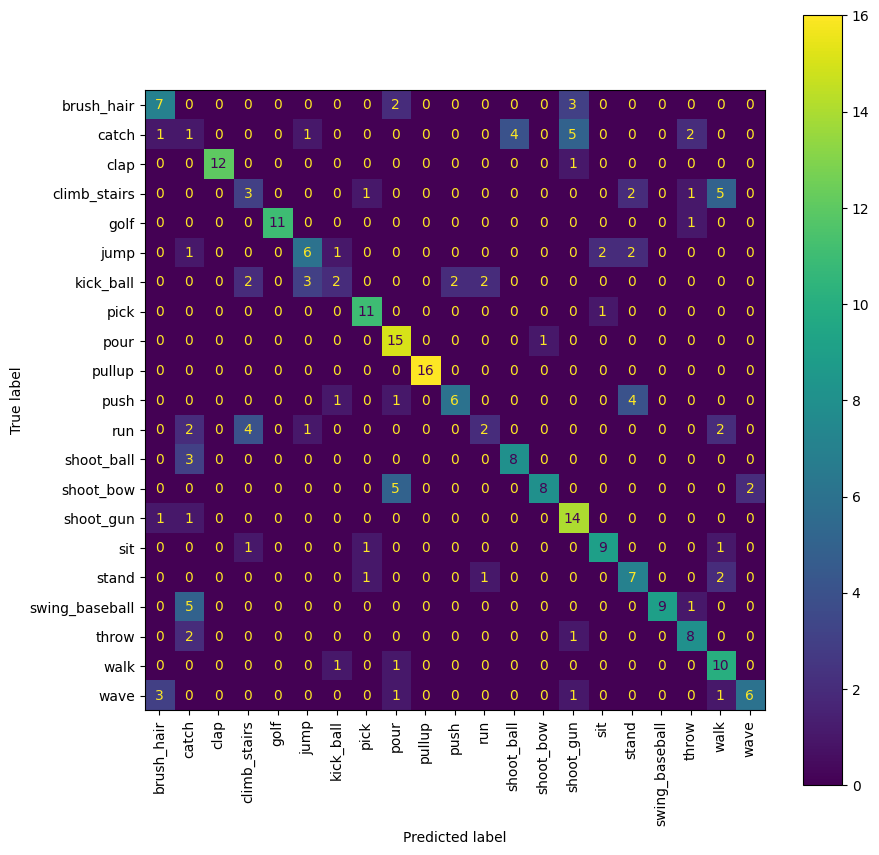

In [25]:
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(testset.get_labels(), outputs)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm, display_labels=JHMDB.actions).plot(
    ax=ax, xticks_rotation="vertical"
)